In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import astropy.units as u
import astropy.constants as c
from scipy import interpolate
from tqdm import tqdm

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

sys.path.append(os.environ['DH_DIR'])
import darkhistory.physics as dhphys

sys.path.append(os.environ['DM21CM_DIR'])
from preprocessing.accretion import *
from preprocessing.halo import *
from dm21cm.utils import load_h5_dict

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../../matplotlibrc')

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/halomod/halo_exclusion.py:18: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  warnings.warn(


# What is the typical Halo at z=10

(1e-10, 9.097304312512907e+23)

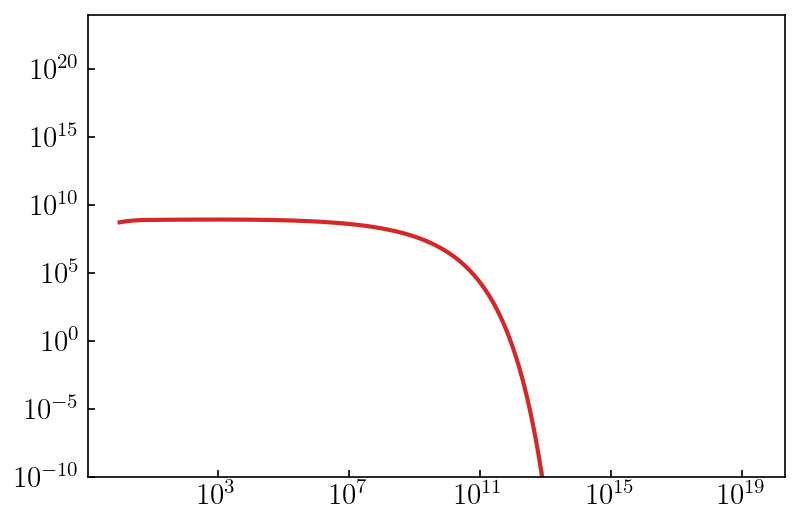

In [ ]:
hmf_data = load_h5_dict("../../data/pwave/m_data.h5")

plt.plot(hmf_data['m_range'], hmf_data['m_range']**2 * hmf_data['dNdM'][11])
plt.loglog()
plt.ylim(1e-10, None)

Pick m_halo = 1e8 m_sun

In [30]:
z = 10
m_halo = 1e2 # [M_sun]
c = cmz(m_halo, z)
print(f'c = {c:.3f}')
rho_s, r_s, r_delta = nfw_info(m_halo, c, z)
print(f'rho_s = {rho_s:.3e} [M_sun / pc^3], r_s = {r_s:.3e} [pc], r_delta = {r_delta:.3e} [pc]')

c = 19.269
rho_s = 3.061e+00 [M_sun / pc^3], r_s = 6.809e-01 [pc], r_delta = 1.312e+01 [pc]


In [33]:
v0 = get_v0_jeans(r_s, rho_s, r_s, r_delta)
v0 = (v0 * u.pc / u.s).to(u.km / u.s).value
print(v0)

0.23944452074967304


In [36]:
rho_inf = (rho_s * u.M_sun / u.pc**3).to(u.g/u.cm**3).value
v = v0 # [km/s]
c_in = 23 # [km/s]
c_inf = v

In [37]:
mPBH = 1e2 # [M_sun]

print(Mdot_BHL(mPBH, rho_inf, v, c_in, c_inf, lambda_fudge=1e-2, z=None))

print(Mdot_PR(mPBH, rho_inf, v, c_in, c_inf, lambda_fudge=1, z=None))

1.874163038715253e-06
2.291884386032751e-14


Probably small halo dominates BHL

# $L-M$

In [8]:
# copied from build_pbhacc_tables.py
hmfdata = load_h5_dict("/n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/data/hmf/hmf.h5")
z_s = hmfdata['z'] # [1]    | redshift
d_s = hmfdata['d'] # [1]    | delta (overdensity)
m_s = hmfdata['m'] # [Msun] | halo mass

zfull_s = np.concatenate((z_s, np.geomspace(z_s[-1], 3000, 300)[1:])) # for Unconditional PS and ST tables
cinf_s = np.geomspace(
    np.sqrt(5/3 * (1+0.) * 10  * u.K * c.k_B / c.m_p).to(u.km/u.s).value, # 0.371 km/s
    np.sqrt(5/3 * (1+1.) * 1e4 * u.K * c.k_B / c.m_p).to(u.km/u.s).value, # 16.6 km/s
    128
) # should cover redshift 4-3000
mPBH = 1e2 # [M_sun]

L_table_BHL = np.load(f"../../data/pbh-accretion/L_table_cache/BHLl2/BHLl2_log10m2.000.npy")
L_table_PR  = np.load(f"../../data/pbh-accretion/L_table_cache/PRc23/PRc23_log10m2.000.npy")

In [9]:
st_table_BHL = np.zeros((len(z_s),len(m_s)))
st_table_PR  = np.zeros((len(z_s),len(m_s)))
dndm = hmfdata['st'] # [1 / cMpc^3 Msun]
for i_z, z in enumerate(tqdm(z_s)):
    st_table_BHL[i_z] = L_table_BHL[i_z] * dndm[i_z]
    st_table_PR[i_z]  = L_table_PR[i_z] * dndm[i_z]

100%|██████████| 300/300 [00:00<00:00, 40516.85it/s]


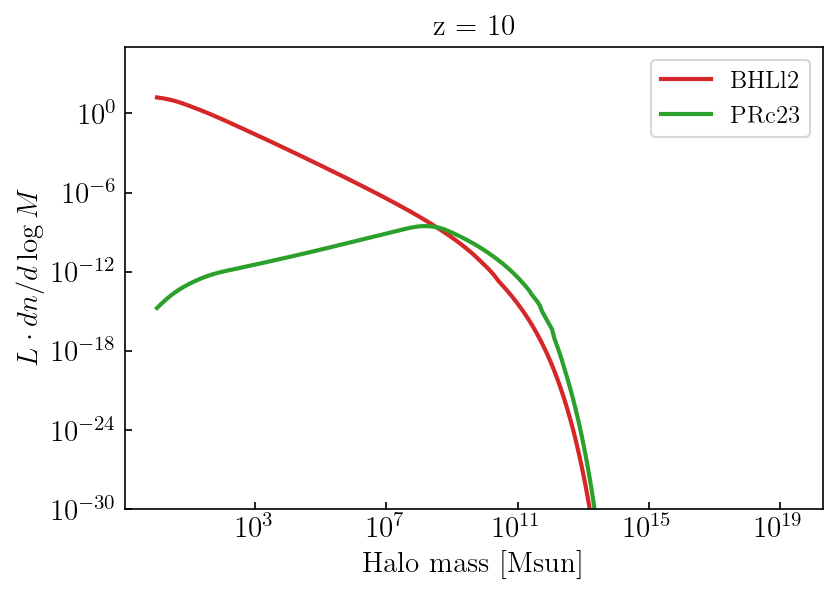

In [18]:
z = 10
i_z = np.argmin(np.abs(z_s - z))
plt.plot(m_s, m_s*st_table_BHL[i_z], label='BHLl2')
plt.plot(m_s, m_s*st_table_PR[i_z], label='PRc23')
plt.ylim(1e-30, 1e5)
plt.loglog()
plt.xlabel('Halo mass [Msun]')
plt.ylabel(r'$L \cdot dn/d\log M$')
plt.title(f'z = {z}')
plt.legend()